In [1]:
import tensorflow as tf
print(tf.__version__)

/anaconda3/envs/dlcv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:

dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=0)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [6]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.03471123],
       [-0.06319656],
       [ 0.04253022],
       [ 0.0135072 ],
       [ 0.0291767 ],
       [ 0.01070827],
       [-0.02805134],
       [ 0.01184553],
       [ 0.01512909],
       [-0.00051758],
       [-0.01652922],
       [ 0.00518939],
       [-0.03212215],
       [ 0.03319504],
       [-0.00979733],
       [ 0.0788461 ],
       [ 0.00345523],
       [ 0.18419334],
       [ 0.25564072],
       [ 0.44642544]], dtype=float32), array([0.01251345], dtype=float32)]


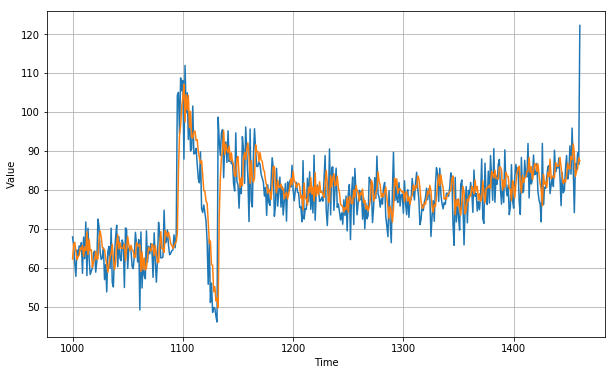

In [7]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1363087

In [9]:
def get_3_layer_DNN():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

_3_layer_model = get_3_layer_DNN()
_3_layer_model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
history = _3_layer_model.fit(dataset, epochs=100, verbose=0, callbacks=[lr_schedule])

[1e-08, 0.001, 0, 300]

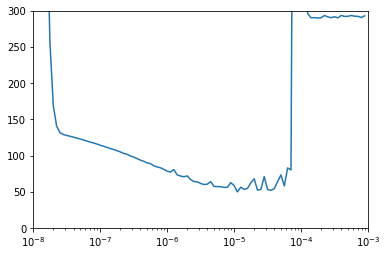

In [22]:
lrs = 1e-8 * (10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [47]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

_3_layer_model = get_3_layer_DNN()
_3_layer_model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9))

history = _3_layer_model.fit(dataset, epochs=500, verbose=0)

In [48]:
def forecaster(_model):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(_model.predict(series[time:time + window_size][np.newaxis]))
    
    forecast = forecast[split_time - window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results

In [49]:
_3_layer_results = forecaster(_3_layer_model)

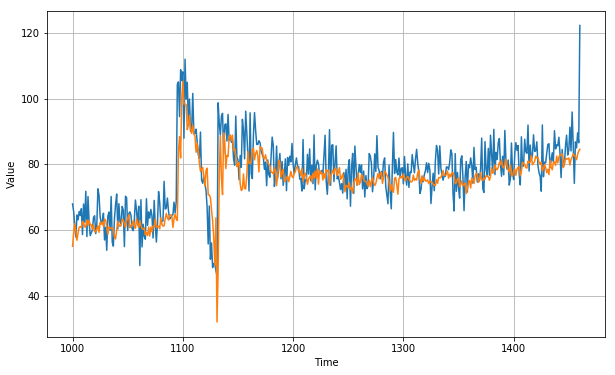

In [50]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, _3_layer_results)

In [51]:
tf.keras.metrics.mean_absolute_error(x_valid, _3_layer_results).numpy()

5.263113

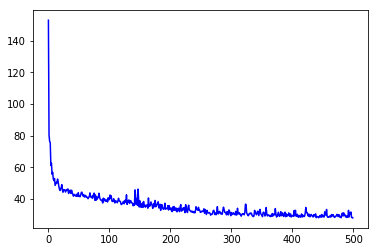

In [52]:
loss = history.history["loss"]
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[53.05285839592059, 48.6707666613392, 49.57630024546201, 50.64866342839507, 50.16552001323897, 52.675403563509285, 50.845826906027256, 48.30090778783425, 46.40749563630094, 45.47971801757812, 46.52141191934802, 47.432341526464086, 49.15456819435985, 45.465003495363845, 44.352660385603755, 46.08158742373752, 45.676586654505776, 45.86645304493069, 44.49168478582323, 45.3699564511014, 46.03071669745691, 45.948302349601825, 46.42298812079675, 43.58266459986107, 44.37314722120147, 45.40763053894043, 45.672231076427344, 43.606176458929006, 45.596923033724124, 44.018136533756845, 43.17271741100193, 41.85713578057043, 43.003159237891126, 42.446106948066, 42.28254335541086, 41.84508725195816, 43.04391884951247, 41.78250747169416, 41.89310061267971, 44.04533003974207, 41.73083422552679, 41.70866051113482, 41.51542885377235, 42.77253028633668, 44.31271730796578, 44.36135818638753, 42.827778405258336, 41.89812862750181, 42.85627920406381, 41.32398008562855, 41.62730217373248, 42.350387982240655, 4

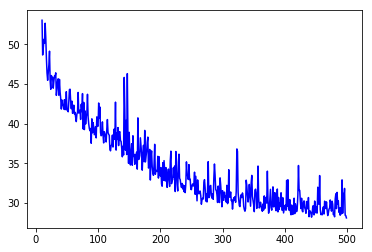

In [53]:
loss = history.history["loss"]
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()